In [12]:
# In[1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import os

# --- Configuration ---
# Define directories
data_dir = os.path.join('..', 'Data') 
filenames = ['Test_cycle_count_1.csv', 'Test_cycle_count_2.csv', 'Test_cycle_count_3.csv']
results_dir = os.path.join('..', 'Results')

# Dictionary format: 'FileName': [Diameter_mm, Length_mm]
sample_dimensions = {
    'Test_cycle_count_1.csv': [15.0, 15.0],
    'Test_cycle_count_2.csv': [14.8, 15.2],
    'Test_cycle_count_3.csv': [15.1, 14.9]
}

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# List to store summary statistics for the final CSV export
summary_results = []

In [13]:
# _____________________________________________________________________________________________________________________
# MAIN PROCESSING LOOP
for filename in filenames:
    file_path = os.path.join(data_dir, filename)
    sample_id = filename.replace('.csv', '')
    if not os.path.exists(file_path):
        print(f"Warning: File {filename} not found. Skipping...")
        continue

    # Retrieve specific dimensions for this sample
    # If the filename isn't in the dict, it defaults to 15.0 for both
    dims = sample_dimensions.get(filename, [15.0, 15.0])
    current_diameter = dims[0]
    current_length = dims[1]
    
    # Recalculate area for this specific sample
    current_area = np.pi * (current_diameter / 2) ** 2
    
    print(f"Processing {filename} (D: {current_diameter}mm, L: {current_length}mm)...")

    # 1. Read data
    df = pd.read_csv(file_path, skiprows=2)
    df = df.rename(columns={"sec": "time", "N": "force", "mm": "disp", "cycle_nb": "cycle"})

    # 2. Signal Filtering
    b, a = signal.butter(4, 0.05)
    df['force_filt'] = signal.filtfilt(b, a, df['force'])
    df['disp_filt'] = signal.filtfilt(b, a, df['disp'])

    # 3. Stress and Strain Calculation
    df['stress_MPa'] = df['force_filt'] / current_area
    df['strain'] = df['disp_filt'] / current_length

    # 4. Global Ultimate Points
    f_ultimate = df['force'].min()
    stress_ultimate = df['stress_MPa'].min()
    strain_ultimate = df['strain'][np.argmin(df['stress_MPa'])]
    disp_ultimate = df['disp'][np.argmin(df['force'])]

    # 5. Cyclic Stiffness and Modulus Analysis
    stiffness_values = []
    modulus_values = []
    force_intercepts = []
    stress_intercepts = []
    cycle_index_ranges = []

    unique_cycles = np.unique(df['cycle'])

    for cycle_id in unique_cycles:
        indices = np.where(df['cycle'] == cycle_id)[0]
        if len(indices) < 10:
            continue

        start_idx = indices[0]
        stop_idx = indices[-1]
        peak_comp_idx = start_idx + np.argmin(df['disp_filt'][start_idx:stop_idx])
        unloading_duration = stop_idx - peak_comp_idx
        
        if unloading_duration < 5:
            continue

        analysis_end_idx = peak_comp_idx + int(unloading_duration / 3)

        k, b_f, _, _, _ = stats.linregress(df['disp_filt'][peak_comp_idx:analysis_end_idx],
                                           df['force_filt'][peak_comp_idx:analysis_end_idx])

        e, b_s, _, _, _ = stats.linregress(df['strain'][peak_comp_idx:analysis_end_idx],
                                           df['stress_MPa'][peak_comp_idx:analysis_end_idx])

        stiffness_values.append(k)
        modulus_values.append(e)
        force_intercepts.append(b_f)
        stress_intercepts.append(b_s)
        cycle_index_ranges.append((peak_comp_idx, stop_idx))

    # Identify the cycle with the maximum stiffness
    max_stiff_idx = np.argmax(stiffness_values)
    k_max = stiffness_values[max_stiff_idx]
    b_f_max = force_intercepts[max_stiff_idx]
    e_max = modulus_values[max_stiff_idx]
    b_s_max = stress_intercepts[max_stiff_idx]
    start_max, stop_max = cycle_index_ranges[max_stiff_idx]

    # 6. Collect Summary Data
    summary_results.append({
        'Sample_ID': sample_id,
        'Diameter_mm': current_diameter,
        'Initial_Length_mm': current_length,
        'Ultimate_Force_N': round(f_ultimate, 2),
        'Ultimate_Stress_MPa': round(stress_ultimate, 2),
        'Max_Stiffness_Nmm': round(k_max, 2),
        'Apparent_Youngs_Modulus_MPa': round(e_max, 2)
    })

Processing Test_cycle_count_1.csv (D: 15.0mm, L: 15.0mm)...
Processing Test_cycle_count_2.csv (D: 14.8mm, L: 15.2mm)...
Processing Test_cycle_count_3.csv (D: 15.1mm, L: 14.9mm)...


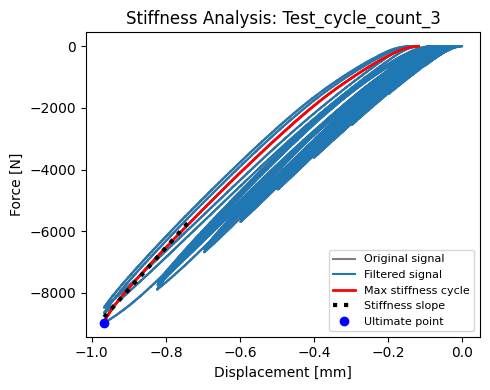

In [14]:
    # 7. Plotting
    # We use plt.show() in IPython to display plots sequentially in the notebook
    
    # Plot 1: Force vs. Displacement
    plt.figure(figsize=(5, 4))
    plt.plot(df['disp'], df['force'], color='black', alpha=0.5, label='Original signal')
    plt.plot(df['disp_filt'], df['force_filt'], label='Filtered signal')
    plt.plot(df['disp_filt'][start_max:stop_max], df['force_filt'][start_max:stop_max], 'r', lw=2, label='Max stiffness cycle')

    slope_indices = range(start_max, start_max + int((stop_max - start_max) / 3))
    plt.plot(df['disp_filt'][slope_indices],
             k_max * df['disp_filt'][slope_indices] + b_f_max, color='black', linestyle='dotted', lw=3, label='Stiffness slope')

    plt.plot(disp_ultimate, f_ultimate, 'ob', label='Ultimate point')
    plt.xlabel('Displacement [mm]')
    plt.ylabel('Force [N]')
    plt.title(f'Stiffness Analysis: {sample_id}')
    plt.legend(loc='lower right', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"Stiffness_{sample_id}.png"), dpi=300)
    plt.show() 

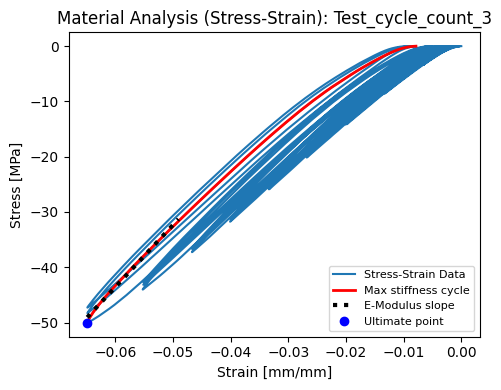

In [15]:
    # Plot 2: Stress vs. Strain
    plt.figure(figsize=(5, 4))
    plt.plot(df['strain'], df['stress_MPa'], label='Stress-Strain Data')
    plt.plot(df['strain'][start_max:stop_max], df['stress_MPa'][start_max:stop_max], 'r', lw=2, label='Max stiffness cycle')

    plt.plot(df['strain'][slope_indices],
             e_max * df['strain'][slope_indices] + b_s_max, color='black', linestyle='dotted', lw=3, label='E-Modulus slope')

    plt.plot(strain_ultimate, stress_ultimate, 'ob', label='Ultimate point')
    plt.xlabel('Strain [mm/mm]')
    plt.ylabel('Stress [MPa]')
    plt.title(f'Material Analysis (Stress-Strain): {sample_id}')
    plt.legend(loc='lower right', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"StressStrain_{sample_id}.png"), dpi=300)
    plt.show()

In [16]:
# 8. Export Summary to CSV
summary_df = pd.DataFrame(summary_results)
summary_df.to_csv(os.path.join(results_dir, 'Summary_Results_Mech_Testing.csv'), index=False, sep=';')

print("--- Analysis Complete ---")
# Display the summary table directly in the notebook output
summary_df

--- Analysis Complete ---


,Sample_ID,Diameter_mm,Initial_Length_mm,Ultimate_Force_N,Ultimate_Stress_MPa,Max_Stiffness_Nmm,Apparent_Youngs_Modulus_MPa
0,Test_cycle_count_1,15.0,15.0,-8970.39,-50.73,13504.59,1146.31
1,Test_cycle_count_2,14.8,15.2,-8970.39,-52.11,13504.59,1193.20
2,Test_cycle_count_3,15.1,14.9,-8970.39,-50.06,13504.59,1123.63
